In [99]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import os
import PIL
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import initializers

In [100]:
# Checkout the labels of our data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train.csv")
df = df[:15000]

In [101]:
df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,CheXpert-v1.0-small/train/patient03732/study1/...,Male,38,Frontal,PA,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,1.0,NaN
14996,CheXpert-v1.0-small/train/patient03732/study1/...,Male,38,Lateral,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,1.0,NaN
14997,CheXpert-v1.0-small/train/patient03733/study1/...,Male,70,Frontal,PA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,NaN,1.0,NaN,NaN,NaN
14998,CheXpert-v1.0-small/train/patient03733/study1/...,Male,70,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,NaN,1.0,NaN,NaN,NaN


In [102]:
# Define the three classes you want to use
class_names = ["No Finding", "Pleural Effusion"]
#class_names = ["Lung Opacity", "Support Devices"]

# Filter the dataframe to only include samples from these classes
df_filtered = df[df[class_names].notna().any(axis=1)][class_names + ["Path"]]

# Shuffle the dataframe and reset the index
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)

In [103]:
df_filtered

,No Finding,Pleural Effusion,Path
0,1.0,NaN,CheXpert-v1.0-small/train/patient00466/study5/...
1,NaN,1.0,CheXpert-v1.0-small/train/patient02696/study11...
2,NaN,1.0,CheXpert-v1.0-small/train/patient03255/study1/...
3,NaN,0.0,CheXpert-v1.0-small/train/patient02166/study1/...
4,NaN,-1.0,CheXpert-v1.0-small/train/patient03720/study2/...
...,...,...,...
9897,NaN,1.0,CheXpert-v1.0-small/train/patient03419/study9/...
9898,1.0,NaN,CheXpert-v1.0-small/train/patient02620/study2/...
9899,NaN,0.0,CheXpert-v1.0-small/train/patient02189/study4/...
9900,NaN,-1.0,CheXpert-v1.0-small/train/patient02026/study1/...


In [104]:
labels = df.iloc[:, 5:].values

labels_dataset = list(df.columns[5:])
labels_dataset

for i in class_names:
  df_filtered[i] = df_filtered[i].apply(lambda x : 1 if x == 1 else 0)

In [105]:
df_filtered

,No Finding,Pleural Effusion,Path
0,1,0,CheXpert-v1.0-small/train/patient00466/study5/...
1,0,1,CheXpert-v1.0-small/train/patient02696/study11...
2,0,1,CheXpert-v1.0-small/train/patient03255/study1/...
3,0,0,CheXpert-v1.0-small/train/patient02166/study1/...
4,0,0,CheXpert-v1.0-small/train/patient03720/study2/...
...,...,...,...
9897,0,1,CheXpert-v1.0-small/train/patient03419/study9/...
9898,1,0,CheXpert-v1.0-small/train/patient02620/study2/...
9899,0,0,CheXpert-v1.0-small/train/patient02189/study4/...
9900,0,0,CheXpert-v1.0-small/train/patient02026/study1/...


In [106]:
# Create a new column called "class" that contains the name of the class for each row
#df_filtered['class'] = ''
#df_filtered.loc[df_filtered['No Finding'] == 1, 'class'] = 'No Finding'
#df_filtered.loc[df_filtered['Pleural Effusion'] == 1, 'class'] = 'Pleural Effusion'

# Filter out the rows that have a 1 in both "No Finding" and "Pleural Effusion"
df_filtered = df_filtered.loc[(df_filtered['No Finding'] == 1) | (df_filtered['Pleural Effusion'] == 1)]
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)


In [107]:
df_filtered

,No Finding,Pleural Effusion,Path
0,0,1,CheXpert-v1.0-small/train/patient01403/study2/...
1,0,1,CheXpert-v1.0-small/train/patient00826/study2/...
2,0,1,CheXpert-v1.0-small/train/patient03225/study2/...
3,1,0,CheXpert-v1.0-small/train/patient01360/study1/...
4,1,0,CheXpert-v1.0-small/train/patient01086/study2/...
...,...,...,...
7149,0,1,CheXpert-v1.0-small/train/patient00868/study2/...
7150,0,1,CheXpert-v1.0-small/train/patient01485/study3/...
7151,0,1,CheXpert-v1.0-small/train/patient02298/study2/...
7152,0,1,CheXpert-v1.0-small/train/patient03067/study2/...


In [108]:
#df_filtered, len(df_filtered)
df_filtered['No Finding']

0       0
1       0
2       0
3       1
4       1
       ..
7149    0
7150    0
7151    0
7152    0
7153    0
Name: No Finding, Length: 7154, dtype: int64

In [109]:
no_finding_counts = df_filtered['Pleural Effusion'].value_counts()
no_finding_counts

1    5378
0    1776
Name: Pleural Effusion, dtype: int64

In [110]:
pleural_effusion_counts = df_filtered['No Finding'].value_counts()
pleural_effusion_counts

0    5378
1    1776
Name: No Finding, dtype: int64

In [111]:
df_sampled = df_filtered.groupby(['No Finding', 'Pleural Effusion']).apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

In [112]:
df_sampled

,No Finding,Pleural Effusion,Path
0,0,1,CheXpert-v1.0-small/train/patient00317/study2/...
1,0,1,CheXpert-v1.0-small/train/patient00142/study3/...
2,0,1,CheXpert-v1.0-small/train/patient01215/study4/...
3,0,1,CheXpert-v1.0-small/train/patient02778/study4/...
4,0,1,CheXpert-v1.0-small/train/patient02382/study10...
...,...,...,...
1995,1,0,CheXpert-v1.0-small/train/patient01382/study1/...
1996,1,0,CheXpert-v1.0-small/train/patient00183/study1/...
1997,1,0,CheXpert-v1.0-small/train/patient02333/study3/...
1998,1,0,CheXpert-v1.0-small/train/patient00656/study1/...


In [113]:
no_finding_counts = df_sampled['No Finding'].value_counts()
no_finding_counts

0    1000
1    1000
Name: No Finding, dtype: int64

In [114]:
pleural_effusion_counts = df_sampled['Pleural Effusion'].value_counts()
pleural_effusion_counts

1    1000
0    1000
Name: Pleural Effusion, dtype: int64

In [115]:
df_filtered

,No Finding,Pleural Effusion,Path
0,0,1,CheXpert-v1.0-small/train/patient01403/study2/...
1,0,1,CheXpert-v1.0-small/train/patient00826/study2/...
2,0,1,CheXpert-v1.0-small/train/patient03225/study2/...
3,1,0,CheXpert-v1.0-small/train/patient01360/study1/...
4,1,0,CheXpert-v1.0-small/train/patient01086/study2/...
...,...,...,...
7149,0,1,CheXpert-v1.0-small/train/patient00868/study2/...
7150,0,1,CheXpert-v1.0-small/train/patient01485/study3/...
7151,0,1,CheXpert-v1.0-small/train/patient02298/study2/...
7152,0,1,CheXpert-v1.0-small/train/patient03067/study2/...


In [116]:
# Create pathnames from image Path
#filenames = []
filenames = ["drive/MyDrive/Deep-Learning/" + fname for fname in df_sampled["Path"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient00317/study2/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient00142/study3/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient01215/study4/view2_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient02778/study4/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient02382/study10/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient02015/study3/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient00886/study2/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient01547/study8/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient00886/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient01817/study10/view1_frontal.jpg']

In [117]:

array_images_classification =[]

for j in range(len(df_sampled["Path"])):
  path = df_sampled["Path"][j]
  classifications = []
  for i in class_names:
    classifications.append(df_sampled[i][j])
  array_images_classification.append(classifications)

In [118]:
#array_images_classification

In [119]:

array_images_classification[:2]
# one-hot encode the labels
labels = np.array(array_images_classification)

In [120]:
len(labels), len(filenames)

(2000, 2000)

## Outro teste

In [121]:
labels_formatted = []

for i in labels:
  if i[0] == 1:
    labels_formatted.append(class_names[0])
  elif i[1] == 1:
    labels_formatted.append(class_names[1])
  else:
    labels_formatted.append(class_names[0])
    

In [122]:
labels_formatted[:10]

['Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion']

In [123]:
labels_formatted = np.array(labels_formatted, dtype=object)
len(labels_formatted)

2000

In [124]:
class_names_formatted = np.array(class_names, dtype=object)
class_names_formatted

array(['No Finding', 'Pleural Effusion'], dtype=object)

In [125]:
len(labels_formatted), len(filenames), len(class_names_formatted)

(2000, 2000, 2)

In [126]:
# Turn a single label into an array of booleans
print(labels_formatted[0])
labels_formatted[0] == class_names_formatted

Pleural Effusion


array([False,  True])

In [127]:
# Turn every label into a boolean array
boolean_labels = [test == class_names_formatted for test in labels_formatted]
boolean_labels[:4]

[array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True])]

In [128]:
# Example: Turning boolean array into intergers
print(labels_formatted[0]) # original label
print(np.where(class_names_formatted == labels_formatted[0])) # index where label occurs
print(boolean_labels[0]) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

Pleural Effusion
(array([1]),)
[False  True]
[0 1]


In [129]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [130]:
len(filenames), len(boolean_labels)

(2000, 2000)

In [131]:
from sklearn.model_selection import train_test_split

# Split them into training and validation
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(1600, 1600, 400, 400)

In [132]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[10])
image.shape

(320, 389)

In [133]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path: str, img_size:int=IMG_SIZE) -> tf.constant:
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channels values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  print(type(image))

  return image



In [134]:
# Simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [135]:
(process_image(X[10]), tf.constant(y[10]))

<class 'tensorflow.python.framework.ops.EagerTensor'>


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03]],
 
        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03]],
 
        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [2.9386878e-05, 2.9386878e-05, 2.9386878e-05],
         [5.1583286e-04, 5.1583286e-04, 5.1583286e-04],
         ...,
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],


In [136]:
BATCH_SIZE = 16
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [137]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
<class 'tensorflow.python.framework.ops.Tensor'>
Creating validation data batches...
<class 'tensorflow.python.framework.ops.Tensor'>


In [138]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [139]:
import matplotlib.pyplot as plt


def show_images(images, labels):
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 3 (for displaying 3 images)
  for i in range(3):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(class_names_formatted[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

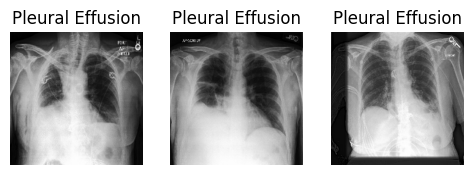

In [140]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# Now let's visualize the data in a training batch
show_images(train_images, train_labels)

In [141]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(class_names_formatted)

# Setup model URL from TensorFlow Hub
#MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/5"
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [142]:
# Create a function which builds a Keras model
from tensorflow.keras.models import Model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):

  # Load the VGG16 model with pre-trained ImageNet weights
  base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

  # Add a custom classification head
  x = base_model.output
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(2, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze the pre-trained layers
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
  )

  # Build the model
  #model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [143]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=5,
            validation_data=val_data,
            callbacks=[early_stopping])
  
  return model

In [144]:
# Fit the model to the data
model = train_model()

Epoch 1/5
100/100 [==============================] - 1311s 13s/step - loss: 0.4859 - accuracy: 0.7688 - val_loss: 0.3613 - val_accuracy: 0.8775
Epoch 2/5
100/100 [==============================] - 1290s 13s/step - loss: 0.3444 - accuracy: 0.8544 - val_loss: 0.3846 - val_accuracy: 0.8600
Epoch 3/5
100/100 [==============================] - 1289s 13s/step - loss: 0.2510 - accuracy: 0.8975 - val_loss: 0.4041 - val_accuracy: 0.8450
Epoch 4/5
100/100 [==============================] - 1281s 13s/step - loss: 0.2149 - accuracy: 0.9194 - val_loss: 0.3658 - val_accuracy: 0.8525


In [145]:
print(model.history.history["accuracy"])

[0.768750011920929, 0.8543750047683716, 0.8974999785423279, 0.9193750023841858]


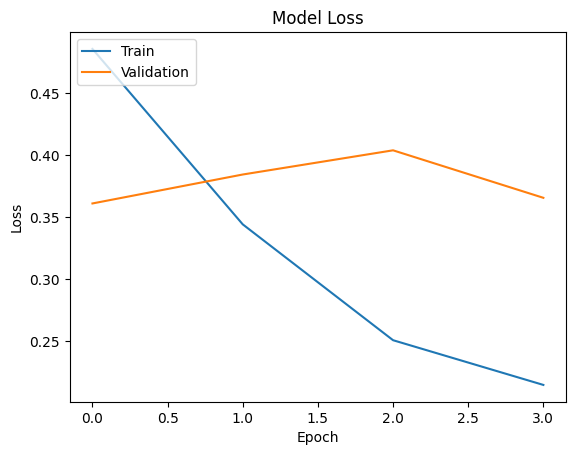

In [146]:
# access the history object and plot the loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

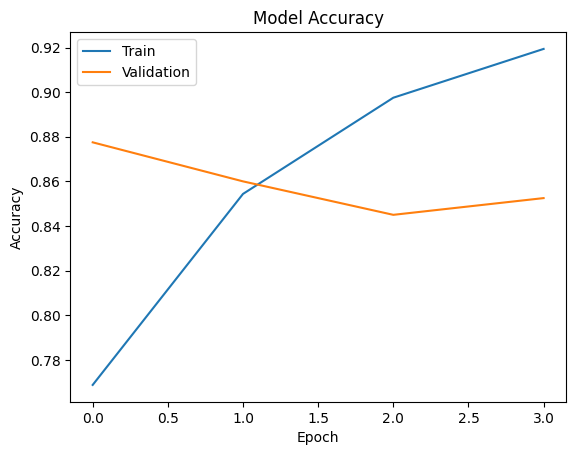

In [147]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [148]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

25/25 [==============================] - 255s 10s/step


array([[9.84761477e-01, 1.52384853e-02],
       [2.09347069e-01, 7.90652871e-01],
       [7.54079223e-02, 9.24592078e-01],
       [1.66581631e-01, 8.33418310e-01],
       [9.80782866e-01, 1.92170851e-02],
       [8.94850075e-01, 1.05149850e-01],
       [2.06630349e-01, 7.93369770e-01],
       [9.93257701e-01, 6.74230698e-03],
       [6.90437388e-03, 9.93095577e-01],
       [9.89363074e-01, 1.06368931e-02],
       [2.93592423e-01, 7.06407607e-01],
       [4.82733697e-01, 5.17266214e-01],
       [9.86449242e-01, 1.35507155e-02],
       [3.97417367e-01, 6.02582633e-01],
       [7.98547789e-02, 9.20145273e-01],
       [9.58154425e-02, 9.04184461e-01],
       [7.61792839e-01, 2.38207176e-01],
       [1.89055011e-01, 8.10944974e-01],
       [3.87667805e-01, 6.12332106e-01],
       [9.50428963e-01, 4.95710224e-02],
       [2.39278525e-02, 9.76072073e-01],
       [9.52638268e-01, 4.73616756e-02],
       [9.95162010e-01, 4.83792881e-03],
       [9.92823601e-01, 7.17637222e-03],
       [9.354533

In [149]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[np.argmax(prediction_probabilities)]


# Get a predicted label based on an array of prediction probabilities

#for i in range(len(predictions)):
  #pred_label = get_pred_label(predictions[i])
  #print(pred_label)

In [150]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separete arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_names[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[7.0028016e-03, 7.0028016e-03, 7.0028016e-03],
         [7.0028016e-03, 7.0028016e-03, 7.0028016e-03],
         [7.0028016e-03, 7.0028016e-03, 7.0028016e-03],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [6.1274513e-05, 6.1274513e-05, 6.1274513e-05],
         [6.5563731e-03, 6.5563731e-03, 6.5563731e-03]],
 
        [[3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
         ...,
         [2.5210083e-03, 2.5210083e-03, 2.5210083e-03],
         [6.1274513e-05, 6.1274513e-05, 6.1274513e-05],
         [6.5563731e-03, 6.5563731e-03, 6.5563731e-03]],
 
        [[2.8011287e-04, 2.8011287e-04, 2.8011287e-04],
         [2.8011287e-04, 2.8011287e-04, 2.8011287e-04],
         [2.8011287e-04, 2.8011287e-04, 2.8011287e-04],
         ...,
         [3.7421216e-03, 3.7421216e-03, 3.7421216e-03],
         [6.1274513e-05, 6.1274513e-05, 6.1274513e-05],


In [151]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

In [152]:
get_pred_label(labels_[0])

'No Finding'

In [153]:
get_pred_label(predictions[0])

'No Finding'

In [154]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Result: {} {:2.0f}% Expected: {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

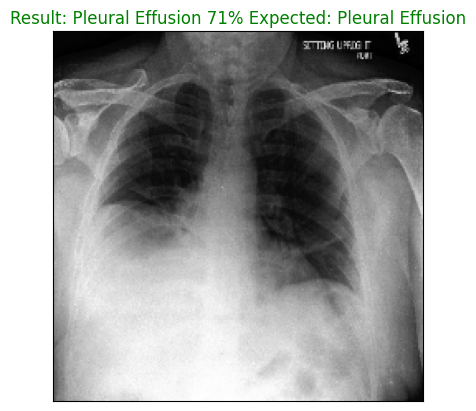

In [155]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,n=10)

In [156]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Deep-Learning/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [157]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

In [158]:
# Save our model trained on 1000 images
save_model(model, suffix="chesxpert-vgg16-balanced-final-Adam")

Saving model to: drive/MyDrive/Deep-Learning/models/20230424-14531682348011-chesxpert-vgg16-balanced-final-Adam.h5...


'drive/MyDrive/Deep-Learning/models/20230424-14531682348011-chesxpert-vgg16-balanced-final-Adam.h5'

In [159]:
# Load a trained model
loaded_images_model = load_model("drive/MyDrive/Deep-Learning/models/20230424-14531682348011-chesxpert-vgg16-balanced-final-Adam.h5")

Loading saved model from: drive/MyDrive/Deep-Learning/models/20230424-14531682348011-chesxpert-vgg16-balanced-final-Adam.h5


In [160]:
# Evaluate the pre-saved model
model.evaluate(val_data)

25/25 [==============================] - 265s 10s/step - loss: 0.3658 - accuracy: 0.8525


[0.36582180857658386, 0.8525000214576721]

In [161]:
# Evaluate the laoded model
loaded_images_model.evaluate(val_data)

25/25 [==============================] - 256s 10s/step - loss: 0.3658 - accuracy: 0.8525


[0.36582180857658386, 0.8525000214576721]

In [162]:
df_test = pd.read_csv("/content/drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid.csv")

In [163]:
# Define the three classes you want to use
class_names = ["No Finding", "Pleural Effusion"]
#class_names = ["Lung Opacity", "Support Devices"]

# Filter the dataframe to only include samples from these classes
df_test_filtered = df_test[df_test[class_names].notna().any(axis=1)][class_names + ["Path"]]

# Shuffle the dataframe and reset the index
df_test_filtered = df_test_filtered.sample(frac=1).reset_index(drop=True)

In [164]:
# Create a new column called "class" that contains the name of the class for each row
#df_filtered['class'] = ''
#df_filtered.loc[df_filtered['No Finding'] == 1, 'class'] = 'No Finding'
#df_filtered.loc[df_filtered['Pleural Effusion'] == 1, 'class'] = 'Pleural Effusion'

# Filter out the rows that have a 1 in both "No Finding" and "Pleural Effusion"
df_test_filtered = df_test_filtered.loc[(df_test_filtered['No Finding'] == 1) | (df_test_filtered['Pleural Effusion'] == 1)]
df_test_filtered = df_test_filtered.sample(frac=1).reset_index(drop=True)


In [165]:
df_test_filtered

,No Finding,Pleural Effusion,Path
0,0.0,1.0,CheXpert-v1.0-small/valid/patient64635/study1/...
1,0.0,1.0,CheXpert-v1.0-small/valid/patient64639/study1/...
2,1.0,0.0,CheXpert-v1.0-small/valid/patient64599/study1/...
3,1.0,0.0,CheXpert-v1.0-small/valid/patient64696/study1/...
4,0.0,1.0,CheXpert-v1.0-small/valid/patient64676/study1/...
...,...,...,...
100,0.0,1.0,CheXpert-v1.0-small/valid/patient64612/study1/...
101,0.0,1.0,CheXpert-v1.0-small/valid/patient64614/study1/...
102,0.0,1.0,CheXpert-v1.0-small/valid/patient64676/study1/...
103,0.0,1.0,CheXpert-v1.0-small/valid/patient64692/study1/...


In [171]:
df_sampled_test = df_test_filtered.groupby(['No Finding', 'Pleural Effusion']).apply(lambda x: x.sample(n=35, random_state=42)).reset_index(drop=True)

In [172]:
df_sampled_test

,No Finding,Pleural Effusion,Path
0,0.0,1.0,CheXpert-v1.0-small/valid/patient64703/study1/...
1,0.0,1.0,CheXpert-v1.0-small/valid/patient64545/study1/...
2,0.0,1.0,CheXpert-v1.0-small/valid/patient64668/study1/...
3,0.0,1.0,CheXpert-v1.0-small/valid/patient64571/study1/...
4,0.0,1.0,CheXpert-v1.0-small/valid/patient64652/study1/...
...,...,...,...
65,1.0,0.0,CheXpert-v1.0-small/valid/patient64615/study1/...
66,1.0,0.0,CheXpert-v1.0-small/valid/patient64556/study1/...
67,1.0,0.0,CheXpert-v1.0-small/valid/patient64599/study1/...
68,1.0,0.0,CheXpert-v1.0-small/valid/patient64595/study1/...


In [173]:
# Create pathnames from image path
#filenames = []
test_filenames = ["drive/MyDrive/Deep-Learning/" + fname for fname in df_sampled_test["Path"]]

# Check the first 10
test_filenames[:10]

['drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64703/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64545/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64668/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64571/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64652/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64596/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64688/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64673/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64614/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64670/study1/view1_frontal.jpg']

In [174]:

array_images_test_classification =[]

for j in range(len(df_sampled_test["Path"])):
  path = df_sampled_test["Path"][j]
  classifications = []
  for i in class_names:
    classifications.append(df_sampled_test[i][j])
  array_images_test_classification.append(classifications)

In [175]:

array_images_classification[:2]
# one-hot encode the labels
labels_test = np.array(array_images_test_classification)

In [176]:
len(labels_test), len(test_filenames)

(70, 70)

In [177]:
labels_test_formatted = []

for i in labels_test:
  if i[0] == 1:
    labels_test_formatted.append(class_names[0])
  elif i[1] == 1:
    labels_test_formatted.append(class_names[1])
  else:
    labels_test_formatted.append(class_names[0])
    

In [178]:
labels_test_formatted[:5]

['Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion']

In [179]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...
<class 'tensorflow.python.framework.ops.Tensor'>


In [180]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_images_model.predict(test_data,
                                             verbose=1)

5/5 [==============================] - 51s 9s/step


In [181]:
# Get custom image predictions labels
custom_pred_labels = [get_pred_label(test_predictions[i]) for i in range(len(test_predictions))]
custom_pred_labels

['Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding'

In [182]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in test_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

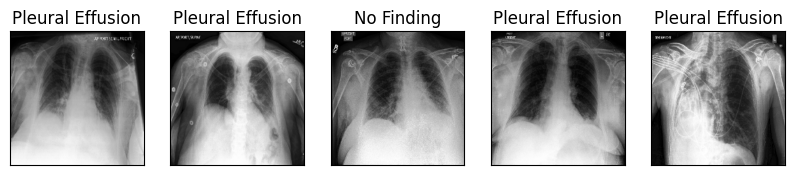

In [183]:
# Check custom image predictions 
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  if i+1 == 6:
    break
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

In [184]:
len(custom_pred_labels), len(labels_test_formatted)

(70, 70)

In [185]:
from sklearn.metrics import accuracy_score

true_labels = labels_test_formatted
predicted_labels = custom_pred_labels

accuracy = accuracy_score(labels_test_formatted, custom_pred_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 87.14%


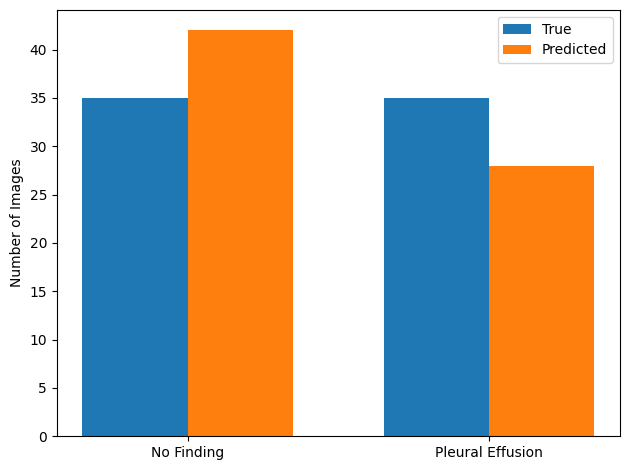

In [186]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of true "No Finding" and "Pleural Effusion" labels
true_counts = {"No Finding": 0, "Pleural Effusion": 0}
for label in true_labels:
    true_counts[label] += 1

# Count the number of predicted "No Finding" and "Pleural Effusion" labels
pred_counts = {"No Finding": 0, "Pleural Effusion": 0}
for i, label in enumerate(predicted_labels):
    if label == "No Finding":
        pred_counts["No Finding"] += 1
    else:
        pred_counts["Pleural Effusion"] += 1

# Create a bar chart
labels = ["No Finding", "Pleural Effusion"]
true_values = [true_counts["No Finding"], true_counts["Pleural Effusion"]]
pred_values = [pred_counts["No Finding"], pred_counts["Pleural Effusion"]]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, true_values, width, label='True')
rects2 = ax.bar(x + width/2, pred_values, width, label='Predicted')
ax.set_ylabel('Number of Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()
